In [1]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use("veux-web")
import numpy as np
from opensees.units.english import ksi
from xara.invoke import invoke_uniaxial

def create_figure():
    fig, ax = plt.subplots(figsize=(6, 4)) # 5,3
    ax.axvline(0, color='gray', lw=0.5)
    ax.axhline(0, color='gray', lw=0.5)

    ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
    ax.set_ylabel(r"$\sigma/\sigma_y$")
    return fig, ax


class Plot:
    def __init__(self, strain, reference=None, label=None):
        self._strain = strain
        self._label = label 
        self._ls = itertools.cycle(["--", "-.", ":"])

        self.fig = plt.figure(figsize=(7,3), layout="tight", dpi=200) #constrained_layout=True)

        gs = GridSpec(1, 3, width_ratios=[6,6,1], figure=self.fig)#, height_ratios=[4, 3]
        self.ax = [
            self.fig.add_subplot(gs[0,0]),
            self.fig.add_subplot(gs[0,1])
        ]

        self.ax[0].axvline(0, color='gray', lw=0.5)
        self.ax[0].axhline(0, color='gray', lw=0.5)
        self.ax[0].set_xlabel(r"$\varepsilon/\varepsilon_y$")
        self.ax[0].set_ylabel(r"$\sigma/F_y$")

        self.ax[1].set_ylabel(r"$E/E_0$")
        self.ax[1].axvline(0, color='gray', lw=0.5)
        self.ax[1].axhline(0, color='gray', lw=0.5)
        if reference is not None:
            self.add(label="Reference", **reference)



    def add(self, label=None, **material):

        Fy = material["Fy"]
        Es = material["E"]
        strain = self._strain
        with invoke_uniaxial("BWBF", **material) as m:
            tangent = []
            stress  = []
            for e in strain:
                stress.append(m.getStress(e*Fy/Es, commit=True)/Fy)
                E = m.getTangent()
                tangent.append(E/Es)


            if label == "Reference":
                self.ax[0].plot(strain, stress, label=label, color="gray", alpha=0.5)
                self.ax[1].plot(tangent, color="gray", alpha=0.8)
            else:
                self.ax[0].plot(strain, stress, next(self._ls), label=label)
                self.ax[1].plot(tangent, next(self._ls))


In [2]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel


## Sharpness, $n$

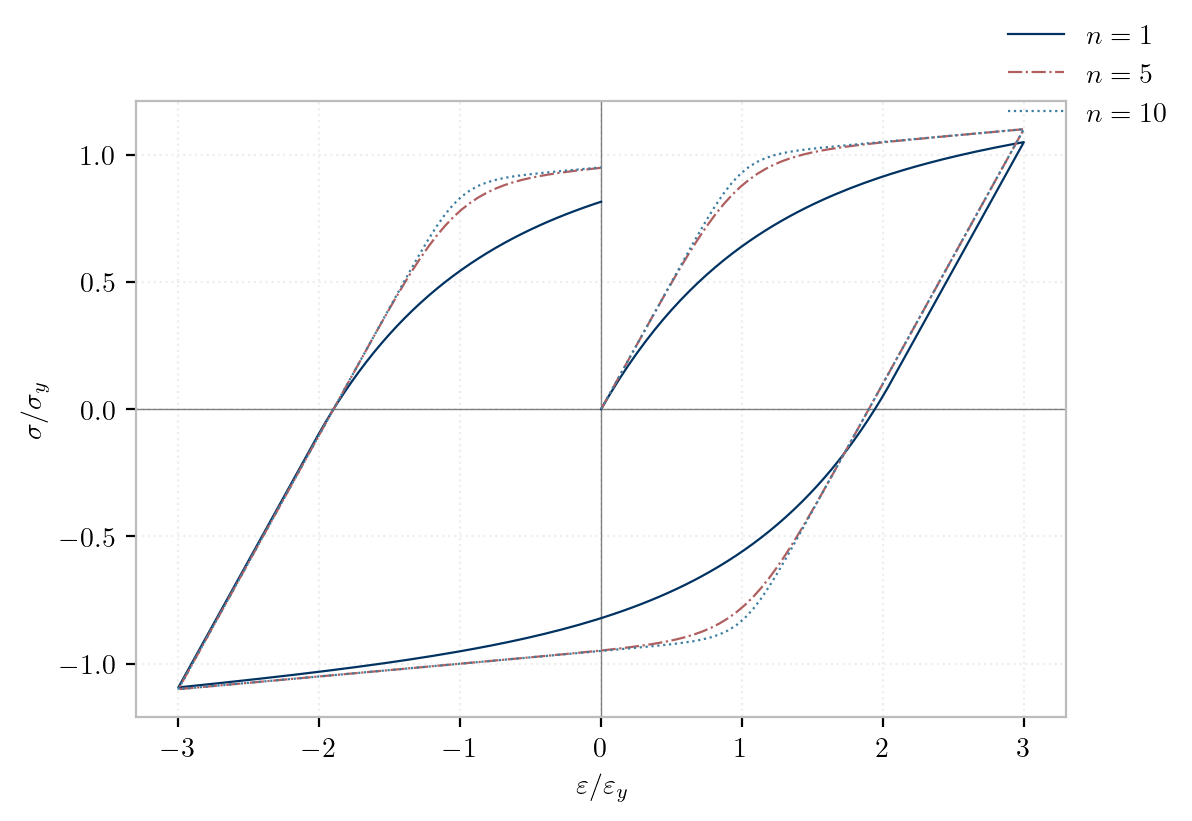

In [3]:
Bs  = 0.05                 # strain-hardening ratio

strain = 3*np.sin(np.linspace(0, 2.0*np.pi, 300))

fig, ax = create_figure()

with invoke_uniaxial("BWBF", Es, Fy, Bs, n=1) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-", label=r"$n=1$")

with invoke_uniaxial("BWBF", Es, Fy, Bs, n=5) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-.", label=r"$n=5$")

with invoke_uniaxial("BWBF", Es, Fy, Bs, n=10) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, ":", label=r"$n=10$")

fig.legend()
fig.savefig("img/bouc-n.png")

## Tangent shape, $\beta$

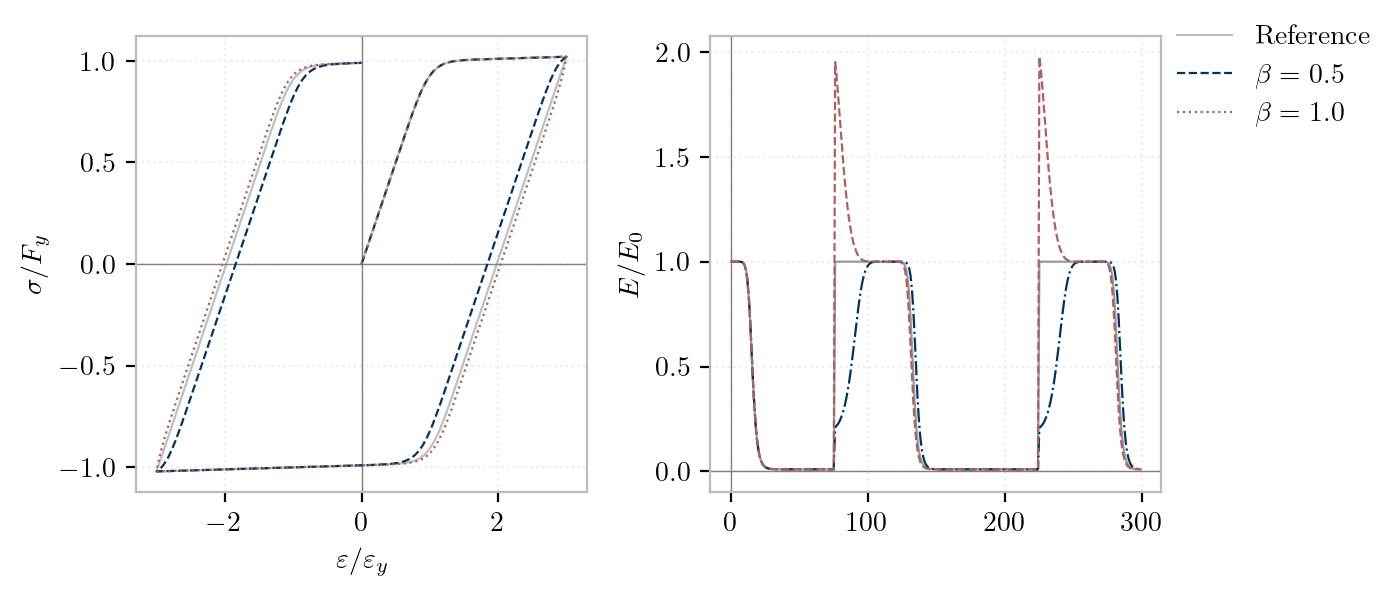

In [4]:

reference = {
    "E":  Es,
    "Fy": Fy,
    "alpha": 0.01,
    "beta": 0.5,
    "n": 10,
}
material = {
    "E":  Es,
    "Fy": Fy,
    "alpha": 0.01,
    "n": 10,
}

strain = 3*np.sin(np.linspace(0, 2.0*np.pi, 300))

p = Plot(strain, reference=reference, label=(r"\beta", "beta"))
p.add(**material, beta=0.1, label=r"$\beta = 0.5$")
p.add(**material, beta=1.0, label=r"$\beta = 1.0$")
p.fig.legend();
p.fig.savefig("img/bouc-beta.png")

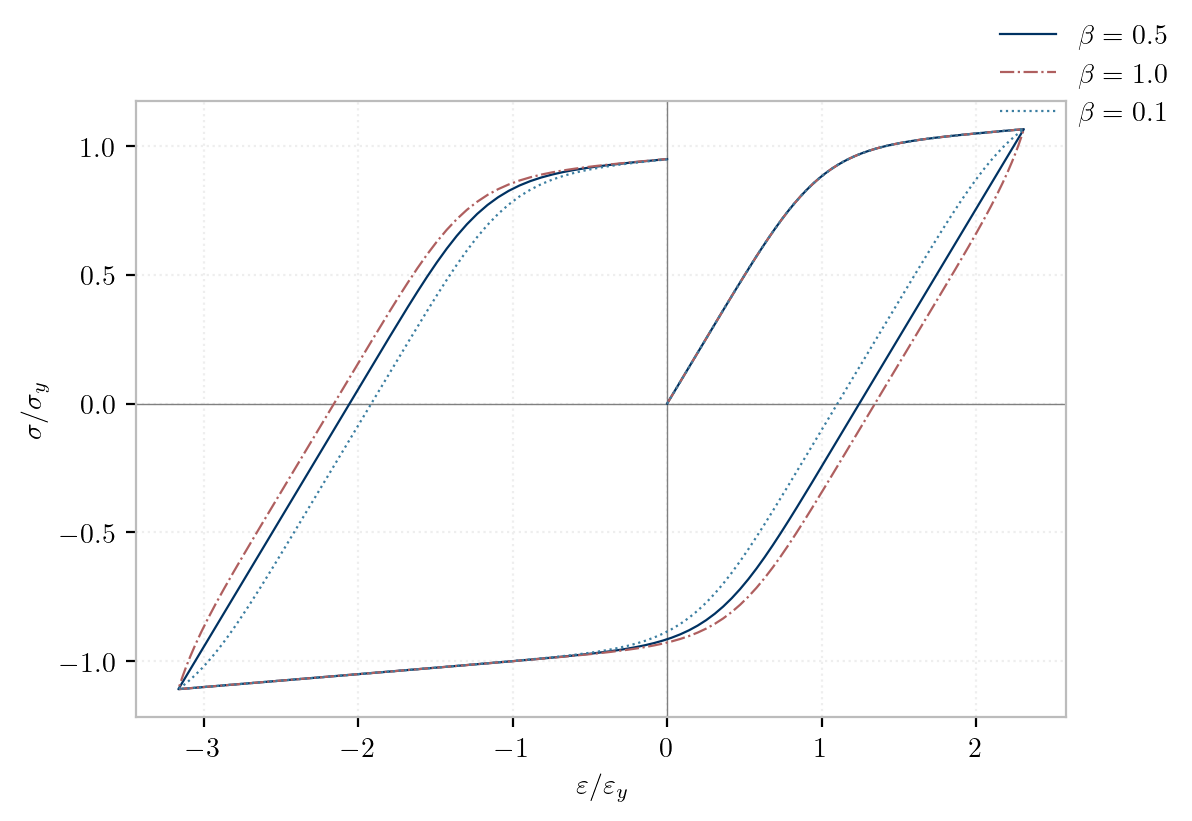

In [5]:
Bs  = 0.05                 # strain-hardening ratio

strain = 3*np.sin(np.linspace(0, 2.0*np.pi, 300))*np.linspace(0.8, 1.1, 300)**2

fig, ax = create_figure()
n = 5

with invoke_uniaxial("BWBF", Es, Fy, Bs, n, beta=0.5) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-", label=r"$\beta = 0.5$")

with invoke_uniaxial("BWBF", Es, Fy, Bs, n, beta=1.0) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-.", label=r"$\beta = 1.0$")

with invoke_uniaxial("BWBF", Es, Fy, Bs, n, beta=0.2) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, ":", label=r"$\beta = 0.1$")

fig.legend();


## Degradation


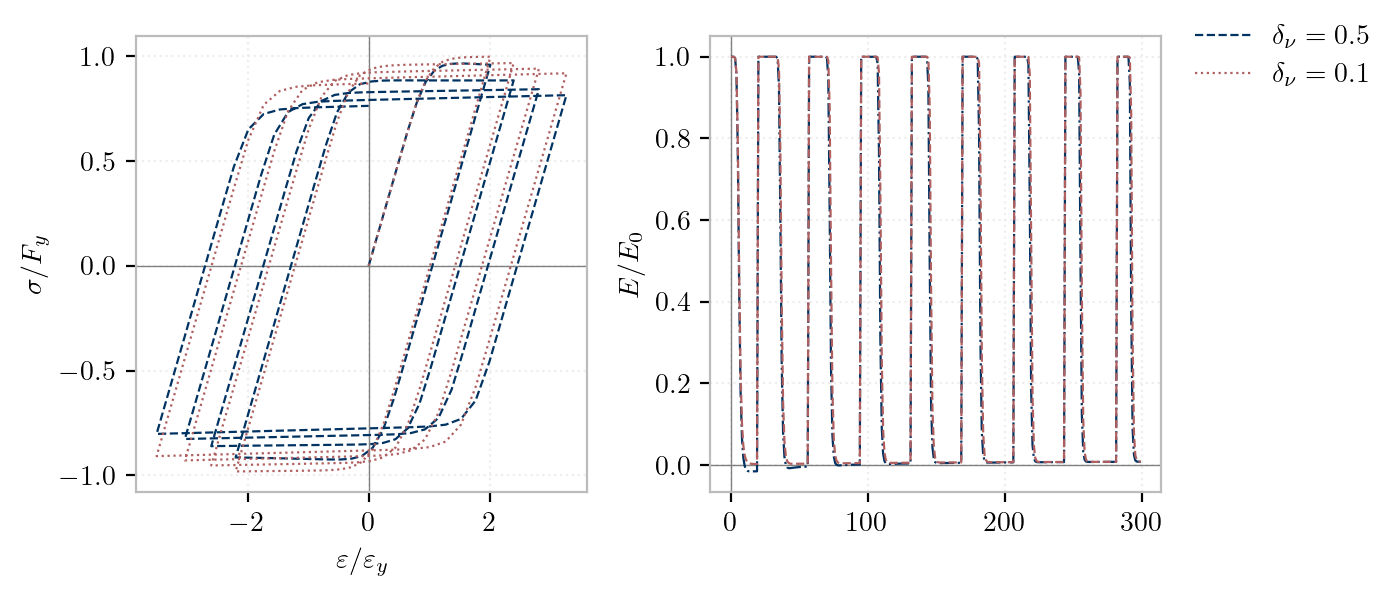

In [6]:

material = {
    "E":  Es,
    "Fy": Fy,
    "alpha": 0.01,
    "n": 10,
}

strain = 3*np.sin(np.linspace(0, 8.0*np.pi, 300))*np.linspace(0.8, 1.1, 300)**2

p = Plot(strain, label=(r"\delta_{\nu}", "delta_v"))
p.add(**material, delta_v=0.5, label=r"$\delta_{\nu} = 0.5$")
p.add(**material, delta_v=0.1, label=r"$\delta_{\nu} = 0.1$")
p.fig.legend();
p.fig.savefig("img/bouc-delta_v.png")


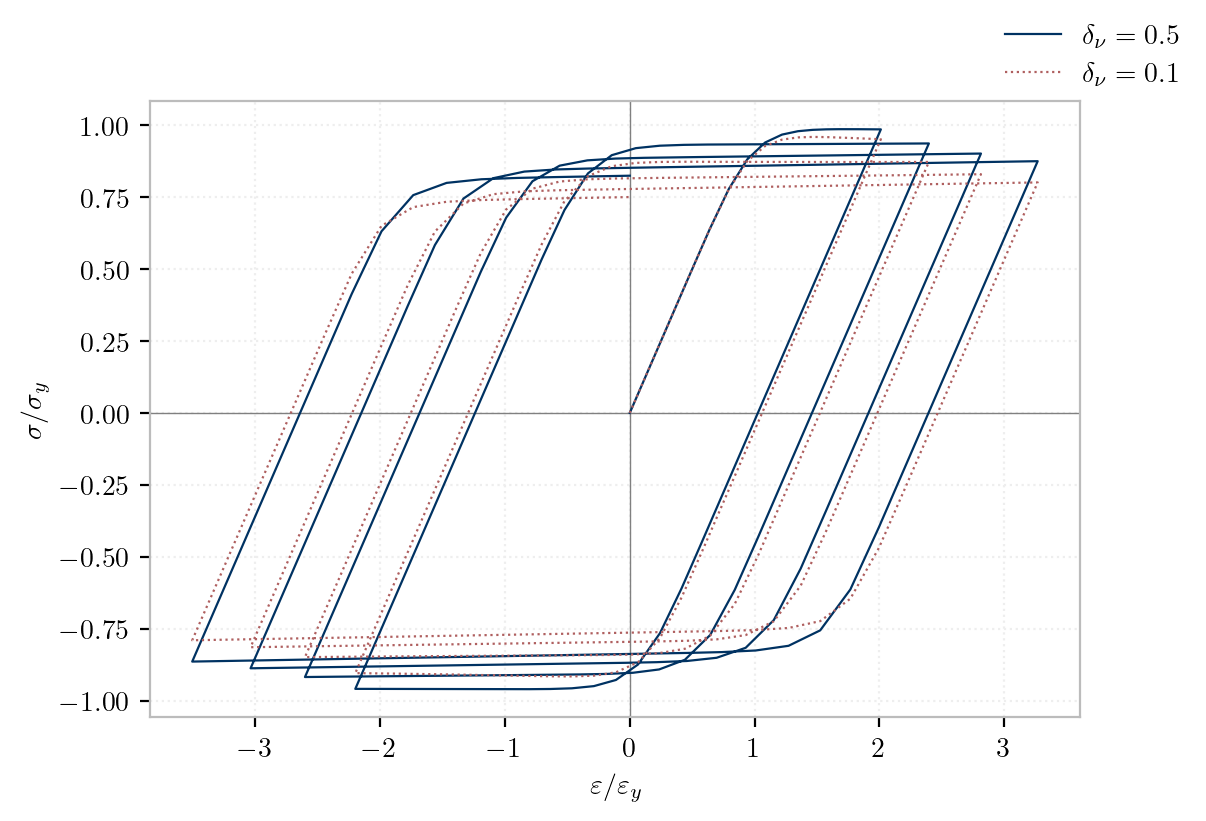

In [7]:
Bs = 0.01


fig, ax = create_figure()
n = 10

with invoke_uniaxial("BWBF", Es, Fy, Bs, n, delta_v=0.2) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-", label=r"$\delta_{\nu} = 0.5$")


with invoke_uniaxial("BWBF", Es, Fy, Bs, n, delta_v=0.6) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, ":", label=r"$\delta_{\nu} = 0.1$")


ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")
fig.legend();

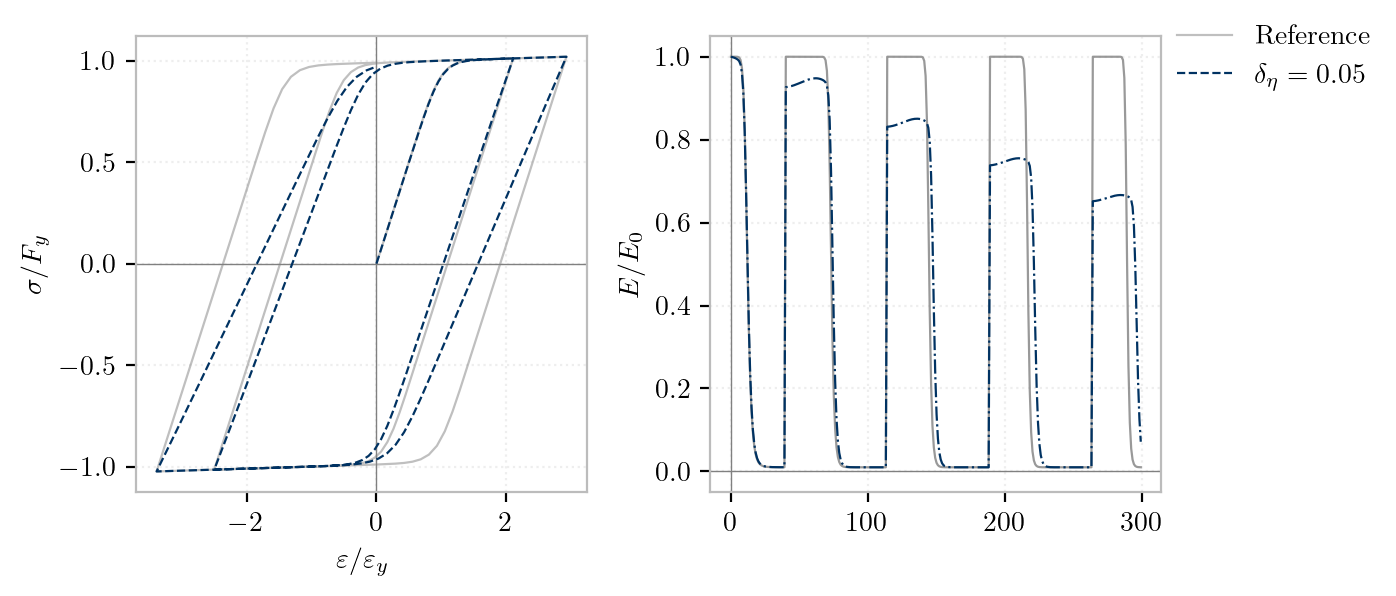

In [8]:

material = {
    "E":  Es,
    "Fy": Fy,
    "alpha": 0.01,
    "n": 10,
}

strain = 3*np.sin(np.linspace(0, 4*np.pi, 300))*np.linspace(0.8, 1.1, 300)**2

p = Plot(strain, reference=material, label=(r"\delta_{\nu}", "delta_v"))
p.add(**material, delta_n=0.05, label=r"$\delta_{\eta} = 0.05$")
p.fig.legend();
p.fig.savefig("img/bouc-delta_n.png")

## Pinching


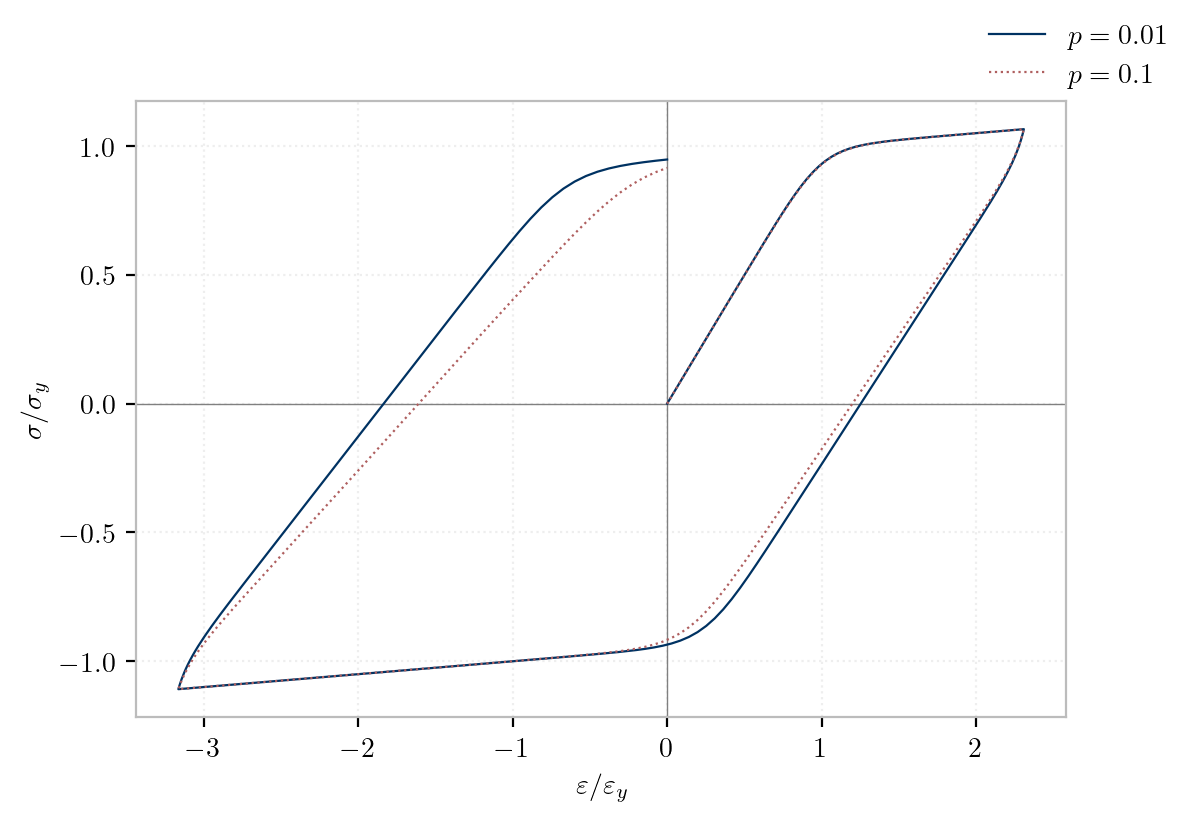

In [9]:

strain = 3*np.sin(np.linspace(0, 2.0*np.pi, 300))*np.linspace(0.8, 1.1, 300)**2

fig, ax = create_figure()

material = {
    "E": Es,
    "Fy": Fy,
    "alpha": 0.05,
    "beta": 1.5,
    "n": 10,
    # "pinch_slope": 1,
    "pinch_start": 0.0,
    "pinch_slip": 1,
    "pinch_rate": 1,
    "pinch_size": 1,
    "pinch_lamda": 0.8
}


with invoke_uniaxial("BWBF", pinch_slope=0.06, **material) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, "-", label=r"$p = 0.01$")


with invoke_uniaxial("BWBF", pinch_slope=0.10, **material) as m:
    stress = [m.getStress(e*Fy/Es, commit=True)/Fy for e in strain]
    ax.plot(strain, stress, ":", label=r"$p = 0.1$")


ax.set_xlabel(r"$\varepsilon/\varepsilon_y$")
ax.set_ylabel(r"$\sigma/\sigma_y$")
fig.legend();
fig.savefig("img/bouc-pinch_slope.png")

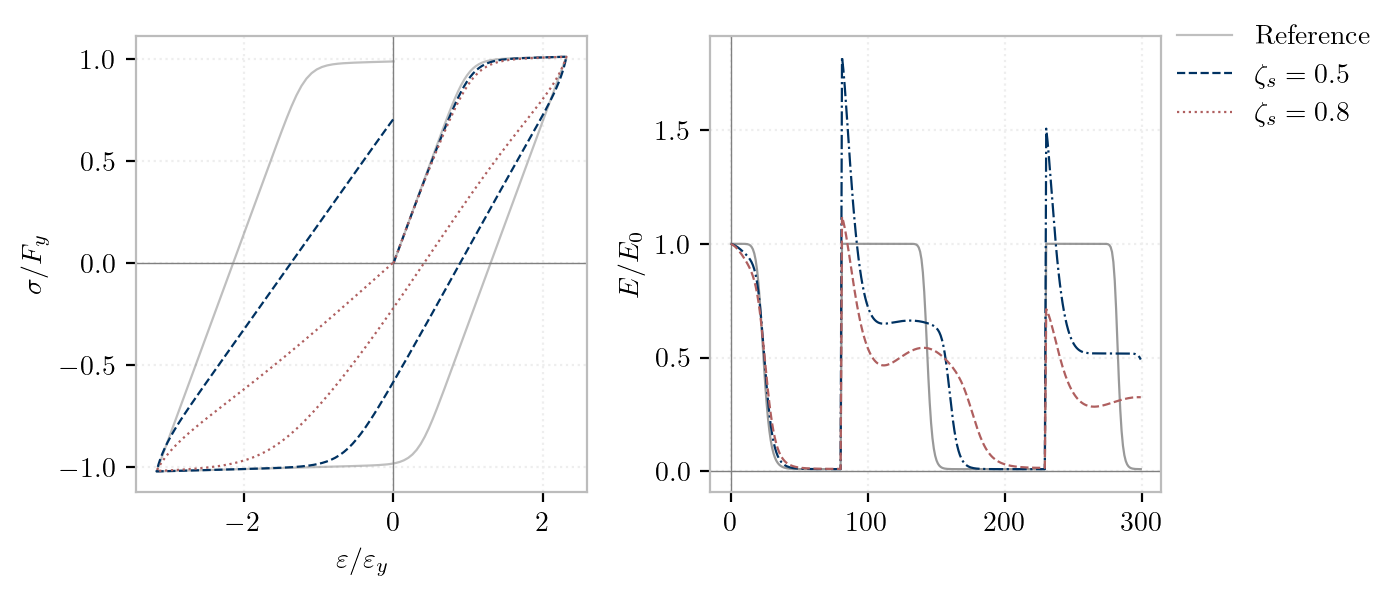

In [ ]:

reference = {
    "E":  Es,
    "Fy": Fy,
    "alpha": 0.01,
    "beta": 0.5,
    "n": 10,
}

material = {
    "E": Es,
    "Fy": Fy,
    "alpha": 0.01,
    "beta": 1.5,
    "n": 10,
    "pinch_slope": 1,
    "pinch_start": 0.0,
    # "pinch_slip": 1,
    "pinch_rate": 1,
    "pinch_size": 1,
    "pinch_lamda": 0.8
}

p = Plot(strain, reference=reference)
p.add(**material, pinch_slip=0.5, label=r"$\zeta_s = 0.5$")
p.add(**material, pinch_slip=0.8, label=r"$\zeta_s = 0.8$")
p.fig.legend();
p.fig.savefig("img/bouc-pinch_slip.png")

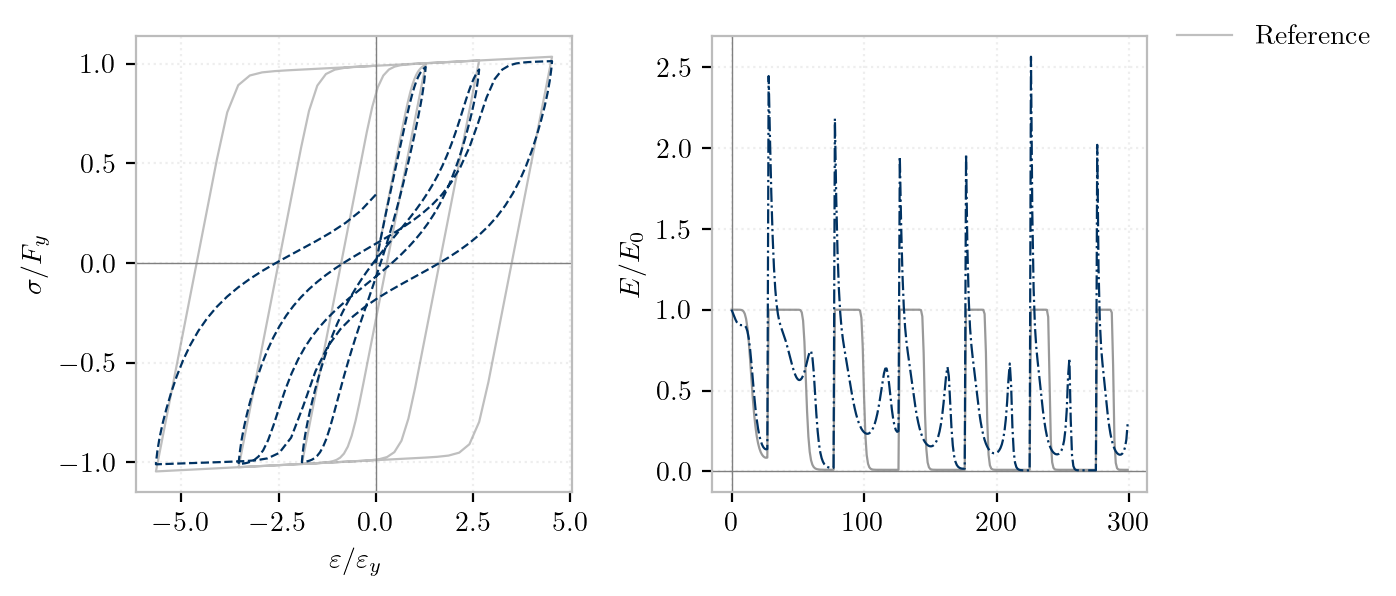

In [11]:


strain = 1*np.sin(np.linspace(0, 6.0*np.pi, 300))*np.linspace(1.0, 2.5, 300)**2

material = {
    "E": Es,
    "Fy": Fy,
    "alpha": 0.01,
    "beta": 1.5,
    "n": 10,
    # Degradation
    "delta_v": 0.05,
    "delta_n": 0.005,
    #
    "pinch_slope": 2,    # p
    "pinch_start": 0.10, # q
    "pinch_slip": 0.9,
    "pinch_rate": 0.001,
    "pinch_size":  0.4,
    "pinch_lamda": 0.8
}

p = Plot(strain, reference=reference)
p.add(**material)
p.fig.legend();